<h1 style="font-size:250%; font-family:cursive; "><b>Regular Expression - Detailed Video in my YouTube Channel</b><a id="0"></a></h1>


<a href="https://youtu.be/fumgmx7q19o"><h1 style="font-size:250%; font-family:cursive; color:#ff6666;"><b>Link to this Video Tutorial</b></h1></a>

1. import lib

In [2]:
import numpy as np
import pandas as pd
# preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
#sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn import preprocessing, decomposition, metrics, pipeline
# visual
import matplotlib.pyplot as plt
import seaborn as sns
# file sys
import os
import warnings
warnings.filterwarnings('ignore')


2. load data

In [5]:
train = pd.read_csv('train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
test = pd.read_csv('test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


3. EDA (Dat about the Data)

In [10]:
# missing data
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [14]:
train.shape

(7613, 5)

In [16]:
test.shape

(3263, 4)

In [18]:
# explore each column
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='count'>

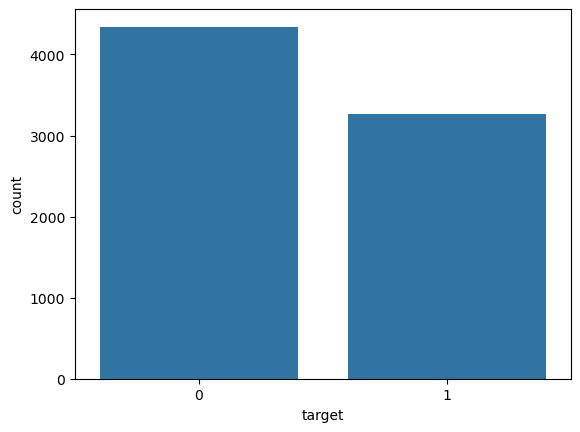

In [20]:
sns.barplot(x = train['target'].value_counts().index,y= train['target'].value_counts())

In [22]:
# text column

disaster_tweet = train[train['target']==1]['text']
disaster_tweet[4]


'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '

In [32]:
non_disaster_tweet = train[train['target']==0]['text']
non_disaster_tweet[22]

'Love skiing'

In [34]:
disaster_tweet[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [36]:
disaster_tweet[1]

'Forest fire near La Ronge Sask. Canada'

In [40]:
non_disaster_tweet[15]

"What's up man?"

In [44]:
# wordcloud
!pip install wordcloud


Text(0.5, 1.0, 'Non_Disaster Tweets')

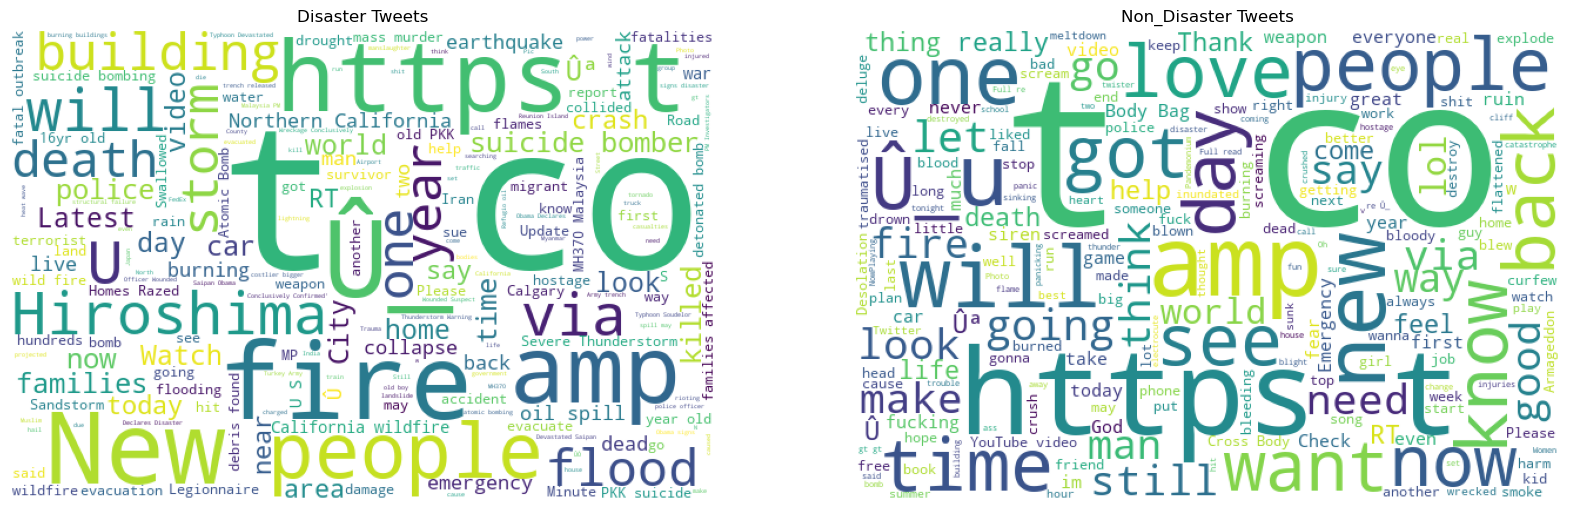

In [48]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [20,8])

# ax1 = disaster
wordcld1 = WordCloud(background_color='white',
                     width=600,
                     height=400).generate(" ".join(disaster_tweet))
ax1.imshow(wordcld1)
ax1.axis('off')
ax1.set_title("Disaster Tweets")
# ax2 = > non-disaster
wordcld2 = WordCloud(background_color='white',
                     width=600,
                     height=400).generate(" ".join(non_disaster_tweet))
ax2.imshow(wordcld2)
ax2.axis('off')
ax2.set_title("Non_Disaster Tweets")


<Axes: xlabel='count', ylabel='keyword'>

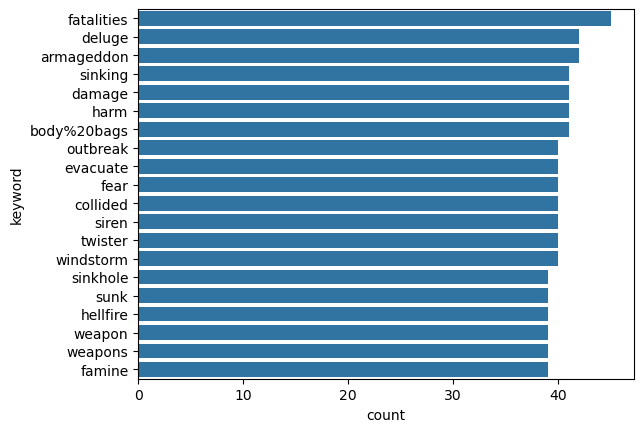

In [50]:
# keyword column
sns.barplot(x = train['keyword'].value_counts()[:20], y= train['keyword'].value_counts()[:20].index, orient = 'h')

<Axes: xlabel='count', ylabel='location'>

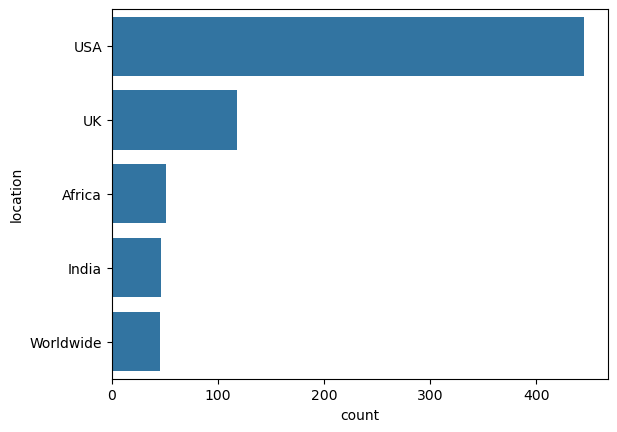

In [52]:
# location
# Replacing the ambigious locations name with Standard names
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)
sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],orient='h')



4. text preprocessing

1. data clean
2. noise
3. normali
4. stopwords

In [56]:
train['text'][:10]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [58]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


In [60]:
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

In [62]:
train['text'][:10]

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
5    rockyfire update  california hwy  closed in bo...
6    flood disaster heavy rain causes flash floodin...
7    im on top of the hill and i can see a fire in ...
8    theres an emergency evacuation happening now i...
9     im afraid that the tornado is coming to our area
Name: text, dtype: object

In [64]:
# token
text = "Are you learning, aren't you"
token1 = nltk.tokenize.WhitespaceTokenizer()
token2 = nltk.tokenize.TreebankWordTokenizer()
token3 = nltk.tokenize.WordPunctTokenizer()
token4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example text: ", text)
print("---------------------------------------------------------")
print("toke=> white: ", token1.tokenize(text))
print()
print("toke=> tree: ", token2.tokenize(text))
print()
print("toke=> words: ", token3.tokenize(text))
print()
print("toke=> Reg: ", token4.tokenize(text))
print()

Example text:  Are you learning, aren't you
---------------------------------------------------------
toke=> white:  ['Are', 'you', 'learning,', "aren't", 'you']

toke=> tree:  ['Are', 'you', 'learning', ',', 'are', "n't", 'you']

toke=> words:  ['Are', 'you', 'learning', ',', 'aren', "'", 't', 'you']

toke=> Reg:  ['Are', 'you', 'learning', 'aren', 't', 'you']



In [66]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'][:10]

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
5    [rockyfire, update, california, hwy, closed, i...
6    [flood, disaster, heavy, rain, causes, flash, ...
7    [im, on, top, of, the, hill, and, i, can, see,...
8    [theres, an, emergency, evacuation, happening,...
9    [im, afraid, that, the, tornado, is, coming, t...
Name: text, dtype: object

In [68]:
# stopword remove
#nltk.download(stopwords)
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['text'] = train['text'].apply(lambda x: remove_stopwords(x))
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))
train['text'][:10]

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
5    [rockyfire, update, california, hwy, closed, d...
6    [flood, disaster, heavy, rain, causes, flash, ...
7                    [im, top, hill, see, fire, woods]
8    [theres, emergency, evacuation, happening, bui...
9                  [im, afraid, tornado, coming, area]
Name: text, dtype: object

In [72]:
# normalize => stemming, lemma
text = "feet cats wolves talked"
tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)
stemmer = nltk.stem.PorterStemmer()
print("stemming", " ".join(stemmer.stem(token)for token in tokens))
lemmatizer = nltk.stem.WordNetLemmatizer()
print("lemmet", " ".join(lemmatizer.lemmatize(token)for token in tokens))

stemming feet cat wolv talk
lemmet foot cat wolf talked


In [74]:
def combine_text(list_text):
    combined_text = " ".join(list_text)
    return combined_text
train['text'] = train['text'].apply(lambda x: combine_text(x))
test['text'] = test['text'].apply(lambda x: combine_text(x))
train['text'][:10]

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
5    rockyfire update california hwy closed directi...
6    flood disaster heavy rain causes flash floodin...
7                           im top hill see fire woods
8    theres emergency evacuation happening building...
9                        im afraid tornado coming area
Name: text, dtype: object

In [76]:
def text_preprocessing(text):
    """clean"""
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopword = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = " ".join(remove_stopword)
    return combined_text

5. tokens to vectors

In [78]:
# vector => feature
count_vector = CountVectorizer()
train_vector = count_vector.fit_transform(train['text'])
test_vector = count_vector.transform(test['text'])

print(train_vector[0].todense())


[[0 0 0 ... 0 0 0]]


In [80]:
#Tf => 
# idf => 1+log(N/n)
tfidf = TfidfVectorizer(min_df=2,max_df=0.5, ngram_range=(1,2))#1=> TF-IDF, 2=>TF*IDF 
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test['text'])

6.build text Classification

In [84]:
clf = LogisticRegression(C=1) # def  =>C=1=>  C dec reg ince=> inverse of regularization strength
scores = model_selection.cross_val_score(clf, train_vector, train['target'], cv = 5, scoring = 'f1')
scores

array([0.6021093 , 0.49827586, 0.57118787, 0.56744186, 0.68839428])

In [88]:
clf.fit(train_vector, train['target'])

LogisticRegression(C=1)

In [90]:
clf_tfidf = LogisticRegression(C=1)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train['target'], cv = 5, scoring = 'f1')
scores

array([0.57229525, 0.4972067 , 0.54093836, 0.46618106, 0.65360641])

In [86]:
def submission(submission_file_path, model, test_vector):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission['target'] = model.predict(test_vector)
    sample_submission.to_csv("DSIT_test.csv", index = False)

In [92]:
submission_file_path = "C:/Users/AJANTHA/Downloads/DSIT"
test_vector = test_tfidf
submission(submission_file_path, clf_tfidf, test_vector)

PermissionError: [Errno 13] Permission denied: 'C:/Users/AJANTHA/Downloads/DSIT'